# **Importing Libraries**

In [ ]:
!pip install meshio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
import meshio

# **Defining Geometry**

In [ ]:
class Geometry:
    """
    Stores geometric and material properties for a beam.

    Attributes
    ----------
    E : float
        Young's modulus of the beam material (Pa).
    I : float
        Second moment of area (m^4).
    L : float
        Length of the beam (m).
    A : float, optional
        Cross-sectional area of the beam (m^2). Default is 1.0.

    Methods
    -------
    __init__(E, I, L, A=1.0)
        Initializes the Geometry object with specified properties.
    """

    def __init__(self, E, I, L, A=1.0):
        """
        Initialize the Geometry object.

        Parameters
        ----------
        E : float
            Young's modulus of the beam material (Pa).
        I : float
            Second moment of area (m^4).
        L : float
            Length of the beam (m).
        A : float, optional
            Cross-sectional area of the beam (m^2). Default is 1.0.
        """
        self.E = E
        self.I = I
        self.L = L
        self.A = A


# **Mesh**

In [ ]:
class Mesh:
    """
    Generates and stores the mesh (nodes and elements) for a 1D beam.

    Attributes
    ----------
    geo : Geometry
        The Geometry object containing beam properties.
    num_elements : int
        Number of elements in the mesh.
    mesh_size : float
        Length of each element.
    nodes : np.ndarray
        Array of node coordinates along the beam.
    elements : list of tuple
        List of element connectivity as (start_node, end_node) pairs.
    num_nodes : int
        Total number of nodes in the mesh.

    Methods
    -------
    __init__(geo, num_elements=None, mesh_size=None)
        Initializes the mesh based on the number of elements or mesh size.
    plot_mesh(show_labels=True)
        Plots the mesh and optionally labels the nodes.
    """
    def __init__(self, geo, num_elements=None, mesh_size=None):
        """
        Initialize the Mesh object.

        Parameters
        ----------
        geo : Geometry
            The Geometry object containing beam properties.
        num_elements : int, optional
            Number of elements to divide the beam into.
        mesh_size : float, optional
            Desired length of each element. If provided, overrides num_elements.

        Raises
        ------
        ValueError
            If neither num_elements nor mesh_size is provided.
        """
        self.geo = geo

        # Case 1: mesh_size provided
        if mesh_size is not None:
            self.num_elements = math.ceil(geo.L / mesh_size)
            self.mesh_size = geo.L / self.num_elements  # adjusted mesh size
        # Case 2: num_elements provided
        elif num_elements is not None:
            self.num_elements = num_elements
            self.mesh_size = geo.L / num_elements
        else:
            raise ValueError("Please provide either 'num_elements' or 'mesh_size'.")

        # Generate mesh data
        self.nodes = np.linspace(0, geo.L, self.num_elements + 1)
        self.elements = [(i, i + 1) for i in range(self.num_elements)]
        self.num_nodes = len(self.nodes)

    def plot_mesh(self, show_labels=True):
        """
        Plot the mesh of the beam.

        Parameters
        ----------
        show_labels : bool, optional
            Whether to display node labels on the plot (default is True).

        Returns
        -------
        None
        """
        plt.plot(self.nodes, np.zeros_like(self.nodes), 'o-', color='steelblue', markersize=8)
        if show_labels:
            for i, x in enumerate(self.nodes):
                plt.text(x, 0.01, f'N{i}', ha='center', fontsize=10, color='darkred')
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        plt.title(f'Mesh: {self.num_elements} elements (Δx = {self.mesh_size:.3f} m)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()


# **Defining Boundary Conditions**

In [ ]:
class BoundaryConditions:
    """
    Manages boundary conditions for beam finite element analysis.

    Attributes
    ----------
    geo : Geometry
        The Geometry object containing beam properties.
    mesh : Mesh
        The Mesh object containing nodes and elements.
    dirichlet : list of tuple
        List of Dirichlet boundary conditions as (dof_index, value).
    neumann : list of tuple
        List of Neumann boundary conditions as (dof_index, value).
    distributed : list of tuple
        List of distributed loads as (element_index, load_function_or_value).

    Methods
    -------
    add_dirichlet(node_index, values)
        Adds Dirichlet (essential) boundary conditions for a node.
    add_neumann(node_index, values)
        Adds Neumann (natural) boundary conditions (force/moment) for a node.
    add_distributed(element_index, load)
        Adds distributed load to an element (uniform or varying).
    """
    def __init__(self, geo, mesh):
        """
        Initialize the BoundaryConditions object.

        Parameters
        ----------
        geo : Geometry
            The Geometry object containing beam properties.
        mesh : Mesh
            The Mesh object containing nodes and elements.
        """
        self.geo = geo
        self.mesh = mesh
        self.dirichlet = []  # (dof_index, value)
        self.neumann = []    # (dof_index, value)
        self.distributed = []  # For distributed loads: (element_index, load_function_or_value)

    def add_dirichlet(self, node_index, values):
        """
        Add Dirichlet (essential) boundary conditions for a node.

        Parameters
        ----------
        node_index : int
            Index of the node where the boundary condition is applied.
        values : tuple
            Tuple of (displacement, rotation) values. Use None for unconstrained DOF.

        Returns
        -------
        None
        """
        disp, rot = values
        if disp is not None:
            self.dirichlet.append((2*node_index, disp))
        if rot is not None:
            self.dirichlet.append((2*node_index + 1, rot))

    def add_neumann(self, node_index, values):
        """
        Add Neumann (natural) boundary conditions (force/moment) for a node.

        Parameters
        ----------
        node_index : int
            Index of the node where the boundary condition is applied.
        values : tuple
            Tuple of (force, moment) values. Use None for unconstrained DOF.

        Returns
        -------
        None
        """
        force, moment = values
        if force is not None:
            self.neumann.append((2*node_index, force))
        if moment is not None:
            self.neumann.append((2*node_index + 1, moment))

    def add_distributed(self, element_index, load):
          """
          Add distributed load to an element.

          Parameters
          ----------
          element_index : int
              Index of the element where the distributed load is applied.
          load : float or callable
              Load value (uniform) or function (for varying load).

          Returns
          -------
          None
          """
          # load can be a constant (uniform), or a function for varying load
          self.distributed.append((element_index, load))
    def plot(self, show_mesh=True):
        """
        Plot the beam mesh and overlay boundary conditions using arrows.

        Parameters
        ----------
        show_mesh : bool, optional
            If True, plot the beam mesh as a line with nodes.

        Returns
        -------
        None
        """
        x = self.mesh.nodes
        y = np.zeros_like(x)
        fig, ax = plt.subplots(figsize=(8, 2))
        if show_mesh:
            ax.plot(x, y, 'o-', color='steelblue', markersize=8, label='Beam mesh')
            for i, xi in enumerate(x):
                ax.text(xi, 0.02, f'N{i}', ha='center', fontsize=10, color='darkred')

        # Dirichlet BCs (supports): draw vertical arrows down for fixed displacement
        for dof, val in self.dirichlet:
            node = dof // 2
            if dof % 2 == 0:  # displacement
                ax.arrow(x[node], 0, 0, -0.08, head_width=0.05, head_length=0.04, fc='green', ec='green', label='Fixed disp' if 'Fixed disp' not in ax.get_legend_handles_labels()[1] else "")
            else:  # rotation
                ax.arrow(x[node], 0, 0.08, 0.08, head_width=0.05, head_length=0.04, fc='orange', ec='orange', label='Fixed rot' if 'Fixed rot' not in ax.get_legend_handles_labels()[1] else "")

        # Neumann BCs (point loads/moments): draw vertical arrows up/down for force, curved arrow for moment
        for dof, val in self.neumann:
            node = dof // 2
            if dof % 2 == 0:  # force
                ax.arrow(x[node], 0, 0, 0.12 * np.sign(val), head_width=0.05, head_length=0.04, fc='red', ec='red', label='Point load' if 'Point load' not in ax.get_legend_handles_labels()[1] else "")
            else:  # moment
                # Draw a circular arrow for moment (approximate with arc and arrowhead)
                theta = np.linspace(0, np.pi/2, 20)
                r = 0.07
                ax.plot(x[node] + r * np.cos(theta), r * np.sin(theta), color='purple')
                ax.arrow(x[node] + r * np.cos(theta[-1]), r * np.sin(theta[-1]), -0.02, 0.02, head_width=0.03, head_length=0.03, fc='purple', ec='purple', label='Moment' if 'Moment' not in ax.get_legend_handles_labels()[1] else "")

        # Distributed loads: draw arrows above each element
        for elem_idx, load in self.distributed:
            n1, n2 = self.mesh.elements[elem_idx]
            x1, x2 = x[n1], x[n2]
            xm = np.linspace(x1, x2, 5)
            for xi in xm:
                ax.arrow(xi, 0.08, 0, 0.06, head_width=0.03, head_length=0.03, fc='blue', ec='blue', label='Distributed load' if 'Distributed load' not in ax.get_legend_handles_labels()[1] else "")

        ax.set_xlabel('x [m]')
        ax.set_yticks([])
        ax.set_title('Boundary Conditions Visualization (Arrows)')
        ax.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# **Finite Element Method**

In [ ]:
class BeamFEM:
  """
    Finite Element Method solver for 1D beam problems.

    Attributes
    ----------
    geo : Geometry
        The Geometry object containing beam properties.
    mesh : Mesh
        The Mesh object containing nodes and elements.
    bc : BoundaryConditions
        The BoundaryConditions object managing all boundary conditions.
    ndof : int
        Total number of degrees of freedom in the system.
    K : np.ndarray
        Global stiffness matrix.
    F : np.ndarray
        Global load vector.
    U : np.ndarray
        Global displacement vector (solution).

    Methods
    -------
    element_stiffness(element_index)
        Computes the local stiffness matrix for a given element.
    element_load_vector(element_index, q)
        Computes the local load vector for a given element and load.
    assemble_global_stiffness()
        Assembles the global stiffness matrix from all element contributions.
    assemble_global_load_vector()
        Assembles the global load vector from all loads and boundary conditions.
    solve()
        Solves the reduced system for unknown displacements and returns the solution, global stiffness matrix, and load vector.
    """
  def __init__(self, geo, mesh, bc):
    """
        Initialize the BeamFEM solver.

        Parameters
        ----------
        geo : Geometry
            The Geometry object containing beam properties.
        mesh : Mesh
            The Mesh object containing nodes and elements.
        bc : BoundaryConditions
            The BoundaryConditions object managing all boundary conditions.
    """
    self.geo = geo
    self.mesh = mesh
    self.bc = bc
    self.ndof = mesh.num_nodes * 2
    self.K = np.zeros((self.ndof, self.ndof))
    self.F = np.zeros((self.ndof, 1))
    self.U = np.zeros((self.ndof, 1))

  def element_stiffness(self, element_index):
    """
        Compute the local stiffness matrix for a given element.

        Parameters
        ----------
        element_index : int
            Index of the element.

        Returns
        -------
        element_stiffness : np.ndarray
            Local stiffness matrix (4x4) for the element.
    """
    node1, node2 = self.mesh.elements[element_index]
    x1, x2 = self.mesh.nodes[node1], self.mesh.nodes[node2]
    element_length =  x2 - x1
    factor = self.geo.E * self.geo.I / (element_length**3)
    element_stiffness = [[12, 6*element_length, -12, 6*element_length],
                              [6*element_length, 4*(element_length**2), -6*element_length, 2*(element_length**2)],
                              [-12, -6*element_length, 12, -6*element_length],
                              [6*element_length, 2*(element_length**2), -6*element_length, 4*(element_length**2)]]
    element_stiffness = np.array(element_stiffness) * factor
    return element_stiffness

  def element_load_vector(self, element_index, q):
    """
        Compute the local load vector for a given element and load.

        Parameters
        ----------
        element_index : int
            Index of the element.
        q : float
            Uniform distributed load value (N/m).

        Returns
        -------
        fe : np.ndarray
            Local load vector (4,) for the element.
    """
    node1, node2 = self.mesh.elements[element_index]
    x1, x2 = self.mesh.nodes[node1], self.mesh.nodes[node2]
    le = x2 - x1
    # For uniform load q (N/m)
    fe = np.array([
        q * le / 2,
        q * le**2 / 12,
        q * le / 2,
        -q * le**2 / 12
    ])
    return fe

  def assemble_global_stiffness(self):
    """
        Assemble the global stiffness matrix from all element contributions.

        Returns
        -------
        K : np.ndarray
            Assembled global stiffness matrix.
    """
    for i in range(len(self.mesh.elements)):
      element_stiffness = self.element_stiffness(i)
      node1, node2 = self.mesh.elements[i]
      dof_indices = [2*node1, 2*node1 + 1, 2*node2, 2*node2 + 1]
      for row_local, row_global in enumerate(dof_indices):
            for col_local, col_global in enumerate(dof_indices):
                self.K[row_global, col_global] += element_stiffness[row_local, col_local]
    return self.K

  def assemble_global_load_vector(self):
    """
        Assemble the global load vector from all loads and boundary conditions.

        Returns
        -------
        F : np.ndarray
            Assembled global load vector.
    """
    # bc: BoundaryConditions object
    for element_index, load in self.bc.distributed:
        # If load is a function, integrate; if constant, use directly
        if callable(load):
            # Numerical integration for varying load (not shown here)
            fe = self.element_load_vector_varying(element_index, load)
        else:
            fe = self.element_load_vector(element_index, load)
        node1, node2 = self.mesh.elements[element_index]
        dof_indices = [2*node1, 2*node1+1, 2*node2, 2*node2+1]
        for i, dof in enumerate(dof_indices):
            self.F[dof] += fe[i]
    # Add point loads
    for dof, value in bc.neumann:
        self.F[dof] += value
    return self.F

  def solve(self):
    """
        Solve the reduced system for unknown displacements.

        Returns
        -------
        U : np.ndarray
            Global displacement vector (solution).
        K : np.ndarray
            Global stiffness matrix.
        F : np.ndarray
            Global load vector.
    """
    fixed_dofs = [dof for dof, val in self.bc.dirichlet]
    all_dofs = np.arange(self.ndof)
    free_dofs = np.setdiff1d(all_dofs, fixed_dofs)
    K_reduced = self.K[np.ix_(free_dofs, free_dofs)]
    F_reduced = self.F[free_dofs]
    U_reduced = np.linalg.solve(K_reduced, F_reduced)
    U = np.zeros((self.ndof, 1))
    U[free_dofs] = U_reduced
    for dof, val in self.bc.dirichlet:
        U[dof] = val
    return U, self.K, self.F

# **Post Processing**

In [ ]:
class PostProcessing:
    """
    Postprocessing utilities for beam finite element analysis.

    Attributes
    ----------
    mesh : Mesh
        The mesh object containing nodes and elements.
    U : np.ndarray
        The global displacement vector (solution).
    K : np.ndarray
        The global stiffness matrix.
    F : np.ndarray
        The global load vector.

    Methods
    -------
    interpolate_displacement(num_points=50)
        Interpolates the displacement field along the beam for smooth visualization.
    plot_displacement(show_labels=True)
        Plots the interpolated displacement curve of the beam.
    reaction_force()
        Computes the reaction forces at all degrees of freedom.
    export_to_vtk(filename="beam_results.vtk")
        Exports mesh and nodal displacement results to VTK format for ParaView visualization.
    """
    def __init__(self, mesh, U, K, F):
        """
        Initialize the PostProcessing class.

        Parameters
        ----------
        mesh : Mesh
            The mesh object containing nodes and elements.
        U : np.ndarray
            The global displacement vector (solution).
        K : np.ndarray
            The global stiffness matrix.
        F : np.ndarray
            The global load vector.
        """
        self.mesh = mesh
        self.U = U
        self.K = K
        self.F = F

    def interpolate_displacement(self, num_points=50):
        """
        Interpolate the displacement field along the beam for smooth visualization.

        Parameters
        ----------
        num_points : int, optional
            Number of interpolation points per element (default is 50).

        Returns
        -------
        x_interp : np.ndarray
            Interpolated physical coordinates along the beam.
        u_interp : np.ndarray
            Interpolated displacement values at those coordinates.
        """
        x_interp = []
        u_interp = []

        for element_index, (node1, node2) in enumerate(self.mesh.elements):
            x1, x2 = self.mesh.nodes[node1], self.mesh.nodes[node2]
            le = x2 - x1

            # Get nodal displacements and rotations
            u1 = self.U[2*node1, 0]
            theta1 = self.U[2*node1+1, 0]
            u2 = self.U[2*node2, 0]
            theta2 = self.U[2*node2+1, 0]

            # Natural coordinates
            xi = np.linspace(-1, 1, num_points)

            # Hermite shape functions
            N1 = (2 - 3*xi + xi**3) / 4
            N2 = le * (1 - xi - xi**2 + xi**3) / 8
            N3 = (2 + 3*xi - xi**3) / 4
            N4 = le * (-1 - xi + xi**2 + xi**3) / 8

            # Interpolate displacement
            u = N1*u1 + N2*theta1 + N3*u2 + N4*theta2

            # Physical coordinates
            x = x1 + (xi + 1) * le / 2

            x_interp.extend(x)
            u_interp.extend(u)

        return np.array(x_interp), np.array(u_interp)

    def plot_displacement(self, show_labels=True):
        """
        Plot the interpolated displacement curve of the beam.

        Parameters
        ----------
        show_labels : bool, optional
            Whether to display axis labels and title (default is True).

        Returns
        -------
        None
        """
        x_interp, u_interp = self.interpolate_displacement()
        plt.plot(x_interp, u_interp, 'o-', color='steelblue', markersize=1)
        plt.xlabel('x [m]')
        plt.ylabel('Displacement [m]')
        plt.title('Beam Displacement')
        plt.show()
    def reaction_force(self):
        """
        Compute the reaction forces at all degrees of freedom.

        Returns
        -------
        R : np.ndarray
            Reaction force vector (nodal force residuals).
        """
        R = np.dot(self.K, self.U) - self.F
        return R
    def export_to_vtk(self, filename="beam_results.vtk"):
        """
        Export mesh and nodal displacement results to VTK format for ParaView visualization.

        Parameters
        ----------
        filename : str, optional
            Name of the output VTK file (default is "beam_results.vtk").

        Returns
        -------
        None
        """
        # Only vertical displacement at each node
        nodal_disp = np.array([self.U[2*i, 0] for i in range(len(self.mesh.nodes))])
        points = np.column_stack([
            self.mesh.nodes,
            np.zeros_like(self.mesh.nodes),
            np.zeros_like(self.mesh.nodes)
        ])
        cells = [("line", np.array(self.mesh.elements))]
        point_data = {"displacement": nodal_disp}
        meshio.write_points_cells(
            filename,
            points,
            cells,
            point_data=point_data
        )
        print(f"Exported results to {filename}")


# **Inputs**

[(0, 1), (1, 2), (2, 3)]


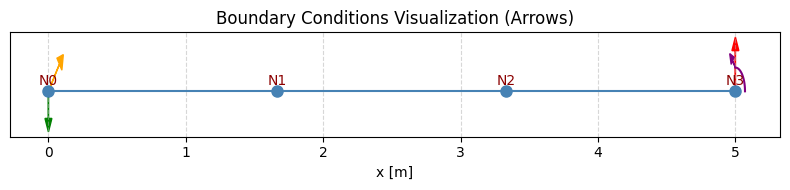

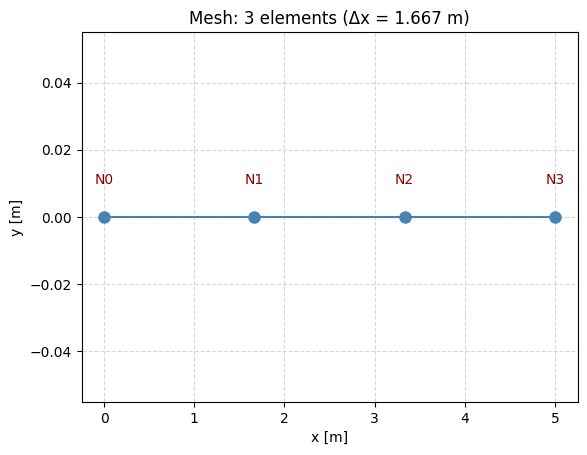

[[ 4.53418560e+06  3.77848800e+06 -4.53418560e+06  3.77848800e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.77848800e+06  4.19832000e+06 -3.77848800e+06  2.09916000e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.53418560e+06 -3.77848800e+06  9.06837120e+06  0.00000000e+00
  -4.53418560e+06  3.77848800e+06  0.00000000e+00  0.00000000e+00]
 [ 3.77848800e+06  2.09916000e+06  0.00000000e+00  8.39664000e+06
  -3.77848800e+06  2.09916000e+06  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.53418560e+06 -3.77848800e+06
   9.06837120e+06  2.79396772e-09 -4.53418560e+06  3.77848800e+06]
 [ 0.00000000e+00  0.00000000e+00  3.77848800e+06  2.09916000e+06
   2.79396772e-09  8.39664000e+06 -3.77848800e+06  2.09916000e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.53418560e+06 -3.77848800e+06  4.53418560e+06 -3.77848800e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   

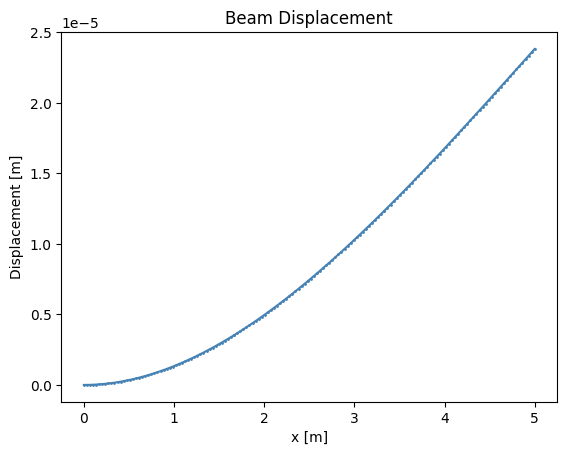

Reaction Force: 
 [[-1.00000000e+00]
 [-5.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.10542736e-15]
 [-1.42108547e-14]
 [-7.10542736e-15]
 [ 7.10542736e-15]]
Exported results to beam_results.vtk


In [ ]:
if __name__ == "__main__":
    geo = Geometry(E=210e9, I=8.33e-6, L=5.0)
    mesh = Mesh(geo, num_elements=3)
    bc = BoundaryConditions(geo, mesh)
    bc.add_dirichlet(0, (0, 0))
    bc.add_neumann(3, (1, 0))
    bc.plot()
    mesh.plot_mesh()
    beam_fem = BeamFEM(geo, mesh, bc)
    beam_fem.element_stiffness(0)
    global_stiff = beam_fem.assemble_global_stiffness()
    global_load = beam_fem.assemble_global_load_vector()
    print(global_stiff)
    print(global_load)
    U, K, F = beam_fem.solve()
    print(U)
    post = PostProcessing(mesh, U, K, F)
    post.plot_displacement()
    R = post.reaction_force()
    print("Reaction Force: \n {}".format(R))
    post.export_to_vtk()